In [1]:
using Revise, OrdinaryDiffEq, Flux, DiffEqFlux, Optim
using Plots, FileIO, JLD2, OffsetArrays, ProgressMeter, Kinetic

┌ Warning: `haskey(::TargetIterator, name::String)` is deprecated, use `Target(; name = name) !== nothing` instead.
│   caller = llvm_compat(::VersionNumber) at compatibility.jl:176
└ @ CUDAnative /home/kit/scc/yy3406/.julia/packages/CUDAnative/ierw8/src/compatibility.jl:176


In [2]:
D = read_dict("../code/shock/ude_shock.txt")
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

case = shock
space = 1d2f1v
nSpecies = 1
interpOrder = 1
limiter = vanleer
cfl = 0.7
maxTime = 250.0
x0 = -35.0
x1 = 35.0
nx = 50
pMeshType = uniform
nxg = 1
umin = -10.0
umax = 10.0
nu = 36
nug = 0
vmin = -10.0
vmax = 10.0
nv = 24
nvg = 0
wmin = -10.0
wmax = 10.0
nw = 24
nwg = 0
vMeshType = rectangle
knudsen = 1.0
mach = 2.0
prandtl = 1.0
inK = 2
omega = 0.5
alphaRef = 1.0
omegaRef = 0.5
nm = 5
tLen = 3
nh = 12



In [3]:
γ = heat_capacity_ratio(inK, 1)
set = Setup(case, space, nSpecies, interpOrder, limiter, cfl, maxTime)
pSpace = PSpace1D(x0, x1, nx, pMeshType, nxg)
μᵣ = ref_vhs_vis(knudsen, alphaRef, omegaRef)
gas = GasProperty(knudsen, mach, prandtl, inK, γ, omega, alphaRef, omegaRef, μᵣ)
vSpace = VSpace1D(umin, umax, nu, vMeshType)
vSpace2D = VSpace2D(vmin, vmax, nv, wmin, wmax, nw, vMeshType)
vSpace3D = VSpace3D(umin, umax, nu, vmin, vmax, nv, wmin, wmax, nw, vMeshType)
wL, primL, hL, bL, bcL, wR, primR, hR, bR, bcR = ib_rh(mach, γ, vSpace.u, inK)
ib = IB2F(wL, primL, hL, bL, bcL, wR, primR, hR, bR, bcR)
ks = SolverSet(set, pSpace, vSpace, gas, ib, pwd())

kn_bzm = hs_boltz_kn(ks.gas.μᵣ, 1.0)
sos = sound_speed(ks.ib.primR, γ)
tmax = (ks.vSpace.u1 + sos) / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tspan = (0.f0, dt)
tran = range(tspan[1], tspan[2], length = tLen)

0.0f0:0.043301642f0:0.086603284f0

In [47]:
ctr = OffsetArray{ControlVolume1D2F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D2F}(undef, ks.pSpace.nx + 1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx ÷ 2
        ctr[i] = ControlVolume1D2F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wL),
            Float32.(ks.ib.primL),
            Float32.(ks.ib.hL),
            Float32.(ks.ib.bL),
        )
    else
        ctr[i] = ControlVolume1D2F(
            ks.pSpace.x[i],
            ks.pSpace.dx[i],
            Float32.(ks.ib.wR),
            Float32.(ks.ib.primR),
            Float32.(ks.ib.hR),
            Float32.(ks.ib.bR),
        )
    end
end
for i = 1:ks.pSpace.nx+1
    face[i] = Interface1D2F(ks.ib.wL, ks.ib.hL)
end

In [5]:
residual = Array{Float32}(undef, 3)
@showprogress for iter = 1:2000
    Kinetic.evolve!(ks, ctr, face, dt)
    Kinetic.update!(ks, ctr, face, dt, residual)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


In [9]:
#--- Boltzmann dataset ---#
f_full = Array{Float32}(undef, nu, nv, nw, nx)
for i = 1:nx
    f_full[:, :, :, i] .= full_distribution(
        ctr[i].h,
        ctr[i].b,
        vSpace.u,
        vSpace.weights,
        vSpace3D.v,
        vSpace3D.w,
        ctr[i].prim,
        ks.gas.γ,
    )
end

phi, psi, phipsi = kernel_mode(
    nm,
    vSpace3D.u1,
    vSpace3D.v1,
    vSpace3D.w1,
    vSpace3D.du[1, 1, 1],
    vSpace3D.dv[1, 1, 1],
    vSpace3D.dw[1, 1, 1],
    vSpace3D.nu,
    vSpace3D.nv,
    vSpace3D.nw,
    alphaRef,
)

function boltzmann(f, p, t)
    Kn, M, phi, psi, phipsi = p
    return boltzmann_fft(f, Kn, M, phi, psi, phipsi)
end

function boltzmann!(df, f, p, t)
    Kn, M, phi, psi, phipsi = p
    df .= boltzmann_fft(f, Kn, M, phi, psi, phipsi)
end

data_boltz = zeros(Float32, nu, nv, nw, nx, tLen)
for i = 1:nx
    prob = ODEProblem(
        boltzmann!,
        f_full[:, :, :, i],
        tspan,
        [kn_bzm, nm, phi, psi, phipsi],
    )

    data_boltz[:, :, :, i, :] = solve(prob, Tsit5(), saveat = tran) |> Array
end

h_boltz = zeros(Float32, nu, nx, tLen)
b_boltz = zeros(Float32, nu, nx, tLen)
for j = 1:tLen, i = 1:nx
    h_boltz[:, i, j], b_boltz[:, i, j] = reduce_distribution(
        data_boltz[:, :, :, i, j],
        vSpace3D.v,
        vSpace3D.w,
        vSpace2D.weights,
    )
end
Y = vcat(h_boltz, b_boltz);

72×50×3 Array{Float32,3}:
[:, :, 1] =
 0.0          7.55173f-26  8.57252f-26  …  6.58008f-24  6.59115f-24
 0.0          1.4871f-23   1.7003f-23      1.57325f-21  1.57571f-21
 0.0          2.13133f-21  2.45658f-21     2.79487f-19  2.79892f-19
 2.26f-43     2.21482f-19  2.57612f-19     3.68913f-17  3.69404f-17
 9.57341f-39  1.66088f-17  1.95188f-17     3.61813f-15  3.62252f-15
 2.22411f-34  8.93273f-16  1.0623f-15   …  2.63658f-13  2.63947f-13
 2.78717f-30  3.41804f-14  4.12103f-14     1.42756f-11  1.42896f-11
 1.88403f-26  9.20509f-13  1.12786f-12     5.74311f-10  5.74808f-10
 6.86955f-23  1.71906f-11  2.14705f-11     1.71671f-8   1.718f-8
 1.3511f-19   2.17995f-10  2.78651f-10     3.81279f-7   3.81522f-7
 1.43338f-16  1.82024f-9   2.39424f-9   …  6.29197f-6   6.29527f-6
 8.20262f-14  9.54875f-9   1.3023f-8       7.71483f-5   7.71804f-5
 2.53199f-11  2.92025f-8   4.17486f-8      0.000702851  0.000703067
 ⋮                                      ⋱               
 0.0232867    0.0232867    

In [6]:
#--- BGK dataset ---#
function bgk!(df, f, p, t)
    H, B, tau = p
    df[1:end÷2, :] .= (H .- f[1:end÷2, :]) ./ tau
    df[end÷2+1:end, :] .= (B .- f[end÷2+1:end, :]) ./ tau
end

X = Array{Float32}(undef, nu * 2, nx)
for i = 1:nx
    X[1:nu, i] .= ctr[i].h
    X[nu+1:end, i] .= ctr[i].b
end

H = Array{Float32}(undef, nu, nx)
B = Array{Float32}(undef, nu, nx)
τ = Array{Float32}(undef, 1, nx)
for i = 1:nx
    H[:, i] .= maxwellian(ks.vSpace.u, ctr[i].prim)
    B[:, i] .= H[:, i] .* ks.gas.K ./ (2.0 .* ctr[i].prim[end])
    τ[1, i] = vhs_collision_time(ctr[i].prim, ks.gas.μᵣ, ks.gas.ω)
end
P = [H, B, τ]

prob = ODEProblem(bgk!, X, tspan, P)
Y1 = solve(prob, Midpoint(), saveat = tran) |> Array;

In [32]:
#--- universal differential equation ---#
model_univ = FastChain(
    #(x, p) -> x .^ 2, # initial guess
    (x, p) -> zeros(eltype(x), axes(x)),
    FastDense(vSpace.nu * 2, vSpace.nu * 2 * nh, tanh),
    #FastDense(vSpace.nu * 2 * nh, vSpace.nu * 2 * nh, tanh),
    FastDense(vSpace.nu * 2 * nh, vSpace.nu * 2),
)

p_model = initial_params(model_univ)

function dfdt(f, p, t)
    h = f[1:nu, :]
    b = f[nu+1:end, :]

    dh = (H .- h) ./ τ .+ model_univ(f, p)[1:nu, :]
    db = (B .- b) ./ τ .+ model_univ(f, p)[nu+1:end, :]

    df = vcat(dh, db)
end

function dfdt!(df, f, p, t)
    h = f[1:nu, :]
    b = f[nu+1:end, :]

    dh = (H .- h) ./ τ .+ model_univ(f, p)[1:nu, :]
    db = (B .- b) ./ τ .+ model_univ(f, p)[nu+1:end, :]

    df[1:nu, :] .= dh
    df[nu+1:end, :] .= db
end

prob_ube = ODEProblem(dfdt, X, tspan, p_model)

function loss(p)
    sol_ube = concrete_solve(prob_ube, Midpoint(), X, p, saveat = tran)
    loss = sum(abs2, Array(sol_ube) .- Y1)
    return loss
end

cb = function (p, l)
    display(l)
    return false
end

#17 (generic function with 1 method)

In [33]:
res = DiffEqFlux.sciml_train(loss, p_model, ADAM(), cb=Flux.throttle(cb, 1), maxiters=200)

4.043678f-13

loss: 3.42e-05:   4%|█▋                                       |  ETA: 0:00:30

1.048086f-5

loss: 4.63e-06:   8%|███▏                                     |  ETA: 0:00:30

7.3464794f-6

loss: 2.06e-06:  12%|████▊                                    |  ETA: 0:00:28

5.9369034f-7

loss: 1.77e-06:  16%|██████▌                                  |  ETA: 0:00:26

6.214142f-7

loss: 1.2e-06:  20%|████████▍                                |  ETA: 0:00:24m

8.6438945f-7

loss: 4.41e-07:  26%|██████████▌                              |  ETA: 0:00:21

3.4096507f-7

loss: 1.71e-07:  30%|████████████▌                            |  ETA: 0:00:19

1.2004706f-7

loss: 6.04e-08:  36%|██████████████▌                          |  ETA: 0:00:17

3.7223124f-8

loss: 5.06e-09:  42%|█████████████████▎                       |  ETA: 0:00:15

7.022365f-9

loss: 4.54e-09:  48%|███████████████████▉                     |  ETA: 0:00:13

4.6523887f-9

loss: 5.16e-10:  55%|██████████████████████▌                  |  ETA: 0:00:11

2.787994f-10

loss: 2.67e-10:  62%|█████████████████████████▍               |  ETA: 0:00:09

1.4003892f-10

loss: 4.26e-08:  69%|████████████████████████████▎            |  ETA: 0:00:07

9.390446f-8

loss: 3.7e-07:  74%|██████████████████████████████▏          |  ETA: 0:00:06m

1.7465408f-7

loss: 7.43e-08:  78%|████████████████████████████████▏        |  ETA: 0:00:05

8.748818f-8

loss: 3.63e-08:  84%|██████████████████████████████████▎      |  ETA: 0:00:04

5.3040367f-8

loss: 1.11e-07:  88%|████████████████████████████████████▎    |  ETA: 0:00:03

1.4572198f-7

loss: 4.47e-08:  94%|██████████████████████████████████████▍  |  ETA: 0:00:01

2.0668688f-8

loss: 1.48e-07:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

1.4391685f-7

loss: 1.52e-07: 100%|█████████████████████████████████████████| Time: 0:00:22


 * Status: success

 * Candidate solution
    Minimizer: [1.70e-03, -3.21e-03, -1.19e-02,  ...]
    Minimum:   1.521412e-07

 * Found with
    Algorithm:     ADAM
    Initial Point: [1.70e-03, -3.21e-03, -1.19e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   27  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [34]:
res = DiffEqFlux.sciml_train(loss, res.minimizer, ADAM(), cb=Flux.throttle(cb, 1), maxiters=200)

2.127031f-7

loss: 2.74e-05:   4%|█▋                                       |  ETA: 0:00:34

1.35101245f-5

loss: 1.43e-05:   8%|███▏                                     |  ETA: 0:00:33

2.3779796f-6

loss: 1.83e-05:  12%|████▊                                    |  ETA: 0:00:30

9.772529f-6

loss: 9.89e-06:  16%|██████▌                                  |  ETA: 0:00:27

8.408909f-6

loss: 1.93e-06:  20%|████████▍                                |  ETA: 0:00:25

2.513932f-6

loss: 8.93e-08:  25%|██████████▎                              |  ETA: 0:00:23

9.7757194f-8

loss: 1.84e-07:  30%|████████████▎                            |  ETA: 0:00:20

7.874616f-8

loss: 9.4e-08:  36%|██████████████▌                          |  ETA: 0:00:18m

4.506293f-8

loss: 6.7e-09:  42%|█████████████████▎                       |  ETA: 0:00:15m

1.9926514f-9

loss: 4.01e-09:  49%|████████████████████▏                    |  ETA: 0:00:13

6.3496057f-9

loss: 2.78e-09:  56%|██████████████████████▊                  |  ETA: 0:00:11

2.5488018f-9

loss: 2.25e-10:  62%|█████████████████████████▋               |  ETA: 0:00:09

3.5366956f-11

loss: 8.4e-11:  70%|████████████████████████████▌            |  ETA: 0:00:07m

1.3117972f-10

loss: 2.58e-11:  76%|███████████████████████████████▍         |  ETA: 0:00:05

5.3951557f-12

loss: 4.88e-12:  84%|██████████████████████████████████▎      |  ETA: 0:00:04

8.2891844f-12

loss: 2.24e-12:  90%|█████████████████████████████████████▏   |  ETA: 0:00:02

8.566154f-13

loss: 1.15e-12:  98%|████████████████████████████████████████ |  ETA: 0:00:01

1.4185647f-12

loss: 9.32e-13: 100%|█████████████████████████████████████████| Time: 0:00:20


 * Status: success

 * Candidate solution
    Minimizer: [1.70e-03, -3.21e-03, -1.19e-02,  ...]
    Minimum:   9.319635e-13

 * Found with
    Algorithm:     ADAM
    Initial Point: [1.70e-03, -3.21e-03, -1.19e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   21  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [23]:
sol_ude = solve(prob_ube, Tsit5(), u0=X, p=res.minimizer, saveat=tran)

retcode: Success
Interpolation: 1st order linear
t: 3-element Array{Float32,1}:
 0.0
 0.043301642
 0.086603284
u: 3-element Array{Array{Float32,2},1}:
 [0.0 7.5517525f-26 … 6.5800825f-24 6.5911486f-24; 0.0 1.4871077f-23 … 1.5732505f-21 1.5757127f-21; … ; 2.2266546f-24 2.2266546f-24 … 4.3071287f-15 4.3236894f-15; 4.690858f-28 4.690858f-28 … 4.2303055f-17 4.2490362f-17]
 [1.6241286f-6 1.6241286f-6 … 1.5538573f-6 1.5538664f-6; 1.3709374f-6 1.3709374f-6 … 1.3116221f-6 1.3116288f-6; … ; 9.85493f-7 9.85493f-7 … 9.4285343f-7 9.4285946f-7; -2.1887504f-6 -2.1887504f-6 … -2.09405f-6 -2.0940622f-6]
 [3.1860006f-6 3.1860006f-6 … 2.919916f-6 2.9199473f-6; 2.6893229f-6 2.6893229f-6 … 2.4647175f-6 2.4647468f-6; … ; 1.93321f-6 1.93321f-6 … 1.7717567f-6 1.7717744f-6; -4.2936003f-6 -4.2936003f-6 … -3.9350125f-6 -3.9350552f-6]

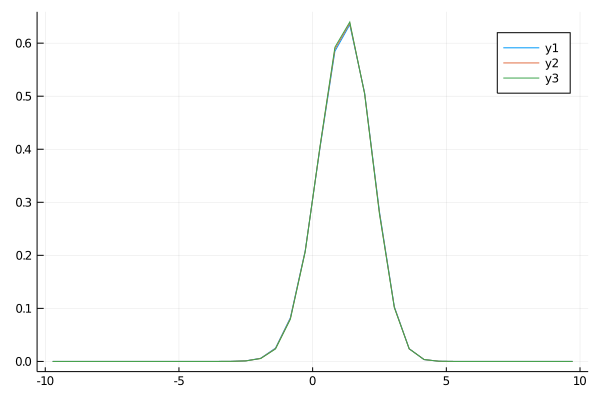

In [24]:
plot(vSpace.u, sol_ude.u[1][1:nu, 25])
plot!(vSpace.u, sol_ude.u[2][1:nu, 25])
plot!(vSpace.u, sol_ude.u[3][1:nu, 25])

In [35]:
function nbe_rhs!(df, f, p, t)
    H = p[1:nu]
    B = p[nu+1:2*nu]
    τ = p[2*nu+1]
    p_nn = p[2*nu+2:end]

    h = f[1:nu]
    b = f[nu+1:end]

    dh = (H .- h) ./ τ .+ model_univ(f, p_nn)[1:nu]
    db = (B .- b) ./ τ .+ model_univ(f, p_nn)[nu+1:end]

    df[1:nu] .= dh
    df[nu+1:end] .= db
end

ube = ODEProblem(
    nbe_rhs!,
    [ctr[1].h; ctr[1].b],
    tspan,
    [H[:, 1]; B[:, 1]; τ[1, 1]; res.minimizer],
)

ODEProblem with uType Array{Float32,1} and tType Float32. In-place: true
timespan: (0.0f0, 0.086603284f0)
u0: Float32[0.0, 0.0, 0.0, 2.23f-43, 9.573438f-39, 2.224118f-34, 2.7871778f-30, 1.884033f-26, 6.869566f-23, 1.3510988f-19  …  0.00012819431, 3.7681857f-6, 5.9746554f-8, 5.1098764f-10, 2.3573545f-12, 5.8661936f-15, 7.874172f-18, 5.701254f-21, 2.2266546f-24, 4.690858f-28]

In [36]:
ube = ODEProblem(
    nbe_rhs!,
    [ctr[1].h; ctr[1].b],
    tspan,
    [H[:, 1]; B[:, 1]; τ[1, 1]; res.minimizer],
)

function step_nbe!(
    fwL,
    fhL,
    fbL,
    w,
    prim,
    h,
    b,
    fwR,
    fhR,
    fbR,
    K,
    γ,
    μ,
    ω,
    u,
    weights,
    p,
    dx,
    tran,
    RES,
    AVG,
)

    #--- record W^{n} ---#
    w_old = deepcopy(w)
    H = maxwellian(u, prim)
    B = H .* K ./ (2.0 .* prim[end])
    τ = vhs_collision_time(prim, μ, ω)

    #--- update W^{n+1} ---#
    @. w += (fwL - fwR) / dx
    prim .= conserve_prim(w, γ)

    #--- record residuals ---#
    @. RES += (w - w_old)^2
    @. AVG += abs(w)

    #--- update f^{n+1} ---#
    sol = concrete_solve(ube, Midpoint(), [h; b], [H; B; τ; p], saveat = tran)
    hstar = sol.u[end][1:length(h)]
    bstar = sol.u[end][length(h)+1:end]
    for i in eachindex(h)
        h[i] = hstar[i] + (fhL[i] - fhR[i]) / dx
        b[i] = bstar[i] + (fbL[i] - fbR[i]) / dx
    end

end

step_nbe! (generic function with 1 method)

In [68]:
prob = ODEProblem(boltzmann!, zeros(nu, nv, nw), tspan, [kn_bzm, nm, phi, psi, phipsi])

function step_be!(
    fwL,
    fhL,
    fbL,
    w,
    prim,
    h,
    b,
    fwR,
    fhR,
    fbR,
    K,
    γ,
    μ,
    ω,
    u,
    weights,
    dx,
    tran,
)

    #--- record W^{n} ---#
    w_old = deepcopy(w)
    H = maxwellian(u, prim)
    B = H .* K ./ (2.0 .* prim[end])
    τ = vhs_collision_time(prim, μ, ω)

    f_star =
        full_distribution(h, b, u, weights, vSpace3D.v, vSpace3D.w, prim, γ)
    df = boltzmann(f_star, [kn_bzm, nm, phi, psi, phipsi], tspan)
    
    df = similar(f_star)
    boltzmann!(df, f_star, [kn_bzm, nm, phi, psi, phipsi], tspan)
    
    #df = (maxwellian(vSpace3D.u, vSpace3D.v, vSpace3D.w, [prim[1],prim[2],0.,0.,prim[3]]) .- f_star) ./ τ
    
    f_star .+= df .* dt

    #prob = ODEProblem(boltzmann!, f_full, tspan, [kn_bzm, nm, phi, psi, phipsi])
    #f_star = Array(solve(prob, Midpoint(), u0=f_full, saveat = tran))[:, :, :, end]

    hstar, bstar =
        reduce_distribution(f_star, vSpace3D.v, vSpace3D.w, vSpace2D.weights)

    for i in eachindex(h)
        h[i] = hstar[i] + (fhL[i] - fhR[i]) / dx
        b[i] = bstar[i] + (fbL[i] - fbR[i]) / dx
        #h[i] = h[i] + (fhL[i] - fhR[i]) / dx
        #b[i] = b[i] + (fbL[i] - fbR[i]) / dx
    end

    #--- update W^{n+1} ---#
    @. w += (fwL - fwR) / dx
    prim .= conserve_prim(w, γ)

end

step_be! (generic function with 1 method)

In [19]:
sumRes = zeros(Float32, axes(ib.wL))
sumAvg = zeros(Float32, axes(ib.wL))

# loop of neural Boltzmann equation
@showprogress for iter = 1:50
    Kinetic.evolve!(ks, ctr, face, dt)

    for i = 2:49
        step_nbe!(
            face[i].fw,
            face[i].fh,
            face[i].fb,
            ctr[i].w,
            ctr[i].prim,
            ctr[i].h,
            ctr[i].b,
            face[i+1].fw,
            face[i+1].fh,
            face[i+1].fb,
            ks.gas.K,
            ks.gas.γ,
            ks.gas.μᵣ,
            ks.gas.ω,
            ks.vSpace.u,
            ks.vSpace.weights,
            res.minimizer,
            ctr[i].dx,
            tran,
            sumRes,
            sumAvg,
        )
    end
end

UndefVarError: UndefVarError: res not defined

In [69]:
sumRes = zeros(Float32, axes(ib.wL))
sumAvg = zeros(Float32, axes(ib.wL))

# loop of neural Boltzmann equation
@showprogress for iter = 1:50
    Kinetic.evolve!(ks, ctr, face, dt)

    for i = 2:49
        step_be!(
            face[i].fw,
            face[i].fh,
            face[i].fb,
            ctr[i].w,
            ctr[i].prim,
            ctr[i].h,
            ctr[i].b,
            face[i+1].fw,
            face[i+1].fh,
            face[i+1].fb,
            ks.gas.K,
            ks.gas.γ,
            ks.gas.μᵣ,
            ks.gas.ω,
            ks.vSpace.u,
            ks.vSpace.weights,
            ctr[i].dx,
            tran,
        )
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:53


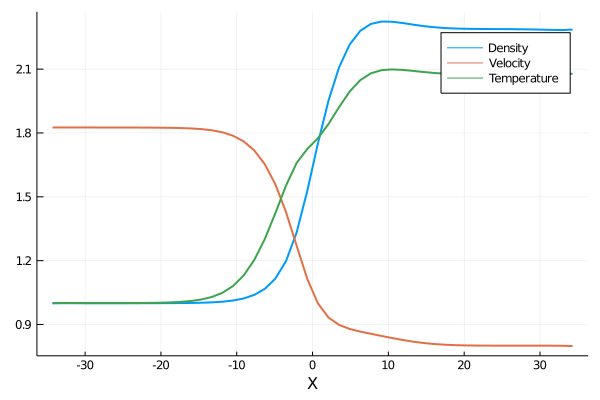

In [70]:
plot_line(ks, ctr)

In [53]:
test = full_distribution(ctr[1].h, ctr[1].b, vSpace.u, vSpace.weights, vSpace3D.v, vSpace3D.w, ctr[1].prim, ks.gas.γ)
df = boltzmann(test, [kn_bzm, nm, phi, psi, phipsi], tspan)

ht, bt =
        reduce_distribution(test, vSpace3D.v, vSpace3D.w, vSpace2D.weights)
dht, dbt =
        reduce_distribution(df, vSpace3D.v, vSpace3D.w, vSpace2D.weights)

([6.811362596739424e-8, -1.8547017247771156e-8, -1.1723245914614689e-7, -1.3760867537216347e-8, 1.8665269751878066e-7, 1.9505919243842368e-7, -2.344312347643365e-8, -2.0020930177675467e-7, -1.5268004464420394e-7, 5.988692763825828e-9  …  8.525365589504857e-8, 5.988692763825834e-9, -1.5268004464420396e-7, -2.0020930177675473e-7, -2.3443123476433623e-8, 1.9505919243842373e-7, 1.8665269751878056e-7, -1.3760867537216354e-8, -1.1723245914614692e-7, -1.8547017247771165e-8], [6.252435909354491e-6, -4.43555371488416e-6, -1.550660345891359e-5, -1.1980603147017353e-6, 2.5231012192034782e-5, 2.7340415169063403e-5, -6.903944571981204e-7, -2.5215953888183995e-5, -2.094194331107915e-5, -6.077744485323947e-7  …  9.691353798066074e-6, -2.6217188032424564e-6, -2.1903545181783084e-5, -2.3095853987483663e-5, 3.1141113396491577e-6, 2.8977758651021603e-5, 2.3203733718003486e-5, -4.22810689172339e-6, -1.6566091201609155e-5, -3.907288572301411e-6])

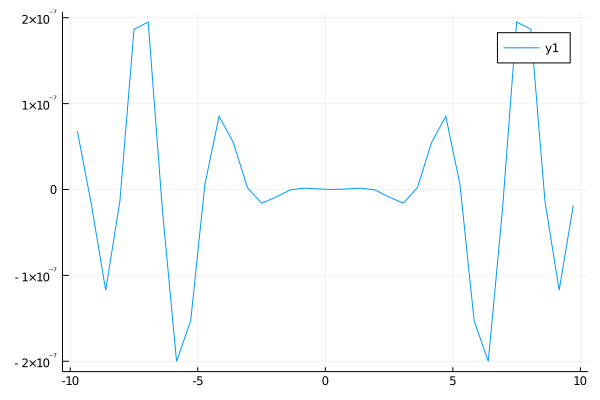

In [54]:
plot(vSpace.u, dht)